In [630]:
# Efficient Frontier  - Markowitz

#Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sb

from tqdm import tqdm
import seaborn as sns

import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff



In [395]:
# Import Data
# 10 stocks + risk-free bond from 04/01/17 to 29/11/19 
# Data are the log-normal daily returns
data_daily = pd.read_csv('data1_1.csv', index_col=0)
data_daily.head()


,ULVR.L,AZN.L,GSK.L,DGE.L,NG.L,HSBA.L,SGE.L,LLOY.L,VOD.L,BP.L
Date,,,,,,,,,,
04/01/17,0.003809,0.008412,0.006064,0.011840,-0.008095,0.006438,0.003067,0.002318,0.016173,0.003859
05/01/17,0.003492,0.016286,0.007607,0.005166,0.006184,-0.012917,0.000765,-0.001854,0.018066,-0.003859
06/01/17,-0.001517,0.000110,0.000000,0.003973,0.003819,0.011274,0.006102,0.019150,0.009031,-0.005428
09/01/17,0.015214,0.012448,0.007863,0.012057,0.006649,-0.000150,0.020324,-0.010372,-0.016218,-0.001946
10/01/17,-0.002844,0.011330,-0.001254,-0.001845,-0.017080,0.003731,-0.014259,0.020638,0.011000,-0.003511


In [396]:
# Annaulized mean returns
# 252 trading days in a year
annual_mean = (1+data_daily.mean())**252-1
print('Annual mean')
print(annual_mean)


Annual mean
ULVR.L    0.158171
AZN.L     0.244584
GSK.L     0.112104
DGE.L     0.179252
NG.L      0.030439
HSBA.L    0.009850
SGE.L     0.076790
LLOY.L    0.025011
VOD.L    -0.027058
BP.L      0.038140
dtype: float64


In [310]:
# Get covariance
cov = data_daily.cov()*252
cov = round(cov, 2)
print('Covariance matrix')
print(cov)

Covariance matrix
        ULVR.L  AZN.L  GSK.L  DGE.L  NG.L  HSBA.L  SGE.L  LLOY.L  VOD.L  BP.L
ULVR.L    0.04   0.01   0.01   0.01  0.01    0.01   0.01   -0.00   0.01  0.01
AZN.L     0.01   0.05   0.02   0.01  0.01    0.01   0.01    0.00   0.01  0.01
GSK.L     0.01   0.02   0.03   0.01  0.01    0.01   0.01    0.00   0.01  0.01
DGE.L     0.01   0.01   0.01   0.02  0.01    0.01   0.01   -0.00   0.01  0.01
NG.L      0.01   0.01   0.01   0.01  0.03    0.00   0.01    0.00   0.01  0.01
HSBA.L    0.01   0.01   0.01   0.01  0.00    0.03   0.01    0.01   0.01  0.01
SGE.L     0.01   0.01   0.01   0.01  0.01    0.01   0.05    0.01   0.01  0.01
LLOY.L   -0.00   0.00   0.00  -0.00  0.00    0.01   0.01    0.04   0.01  0.01
VOD.L     0.01   0.01   0.01   0.01  0.01    0.01   0.01    0.01   0.04  0.01
BP.L      0.01   0.01   0.01   0.01  0.01    0.01   0.01    0.01   0.01  0.04


In [623]:
# Random Portfolios
# Asses to include in each portfolio
n_assets = data_daily.shape[1]
# Portfolios to generate
n_portfolios = 1000

# mean variance pairs (plot purposes)
mean_variance_pairs = []
weights_list = []
tickers_list = []

np.random.seed(1234) #random seed

# Portfolio random generator
for i in range(n_portfolios):
    # Choose assets randomdly
    assets = list(data_daily.columns)

    # Choose weights randomly
    weights = np.random.rand(n_assets)
    # Weights sum to 1
    weights = weights/sum(weights) #proportion of the asset

    # Additional loop over assets pairs
    # Compute portfolio return and variance
    portfolio_var = 0
    portfolio_return = 0
    for i in range(len(assets)):
        portfolio_return += weights[i] * annual_mean.loc[assets[i]]
        for j in range(len(assets)):
            # Add variance (when i==j) / covariance for each pair
            portfolio_var += weights[i] * weights[j] * cov.loc[assets[i], assets[j]]
        
    # mean / variance pairs to a list (plot)
    mean_variance_pairs.append([portfolio_return, portfolio_var])
    weights_list.append(weights)
    tickers_list.append(assets)
    


In [625]:
# Plot risk vs. return of the randomly portfolios
# Convert the list into an array
mean_variance_pairs = np.array(mean_variance_pairs)

risk_free_rate = 0.023

# Plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=mean_variance_pairs[:,1]**0.5, y=mean_variance_pairs[:,0], 
                      marker=dict(color=(mean_variance_pairs[:,0]-risk_free_rate)/(mean_variance_pairs[:,1]**0.5), 
                                  showscale=True, 
                                  size=7,
                                  line=dict(width=1),
                                  colorscale="RdBu",
                                  colorbar=dict(title="Sharpe<br>Ratio")
                                 ), 
                      mode='markers',
                      text=[str(np.array(tickers_list[i])) + "<br>" + str(np.array(weights_list[i]).round(2)) for i in range(len(tickers_list))]))
fig.update_layout(template='plotly_white',
                  xaxis=dict(title='Annualized Risk (Volatility)'),
                  yaxis=dict(title='Annualized Return'),
                  title='Sample of Random Portfolios',
                  width=850,
                  height=500)
fig.update_layout(yaxis_range=[0.02,0.16])
fig.update_layout(xaxis_range=[0.09, 0.23])
fig.update_layout(coloraxis_colorbar=dict(title="Sharpe Ratio"))


In [626]:
# Sample only from efficient frontier
n_assets = data_daily.shape[1]

mean_variance_pairs = []
weights_list = []
tickers_list = []
np.random.seed(1234) #random seed

for i in tqdm(range(1000)):
    next_i = False
    while True:
        assets = list(data_daily.columns)
        weights = np.random.rand(n_assets)
        weights = weights / sum(weights)

        portfolio_return = 0
        portfolio_var = 0
        for i in range(len(assets)):
            portfolio_return += weights[i] * annual_mean[assets[i]]
            for j in range(len(assets)):
                portfolio_var += weights[i] * weights[j] * cov.loc[assets[i], assets[j]]
        

        for R, V in mean_variance_pairs:
            if (R>portfolio_return) & (V<portfolio_var):
                next_i = True
                break
        if next_i:
            break

        mean_variance_pairs.append([portfolio_return, portfolio_var])
        weights_list.append(weights)
        tickers_list.append(assets)
        break


100%|██████████| 1000/1000 [00:00<00:00, 1407.75it/s]


In [627]:
# How many portfolios are in the efficient frontier
len(mean_variance_pairs)

29

In [629]:
# Plot the risk vs. return of the portfolios
# Convert the list into an array
mean_variance_pairs = np.array(mean_variance_pairs)

risk_free_rate = 0.023

fig = go.Figure()
fig.add_trace(go.Scatter(x=mean_variance_pairs[:,1]**0.5, y=mean_variance_pairs[:,0], 
                      marker=dict(color=(mean_variance_pairs[:,0]-risk_free_rate)/(mean_variance_pairs[:,1]**0.5), 
                                  showscale=True, 
                                  size=7,
                                  line=dict(width=1),
                                  colorscale="RdBu",
                                  colorbar=dict(title="Sharpe<br>Ratio")
                                 ), 
                      mode='markers',
                      text=[str(np.array(tickers_list[i])) + "<br>" + str(np.array(weights_list[i]).round(2)) for i in range(len(tickers_list))]))
fig.update_layout(template='plotly_white',
                  xaxis=dict(title='Annualized Risk (Volatility)'),
                  yaxis=dict(title='Annualized Return'),
                  title='Sample of Random Portfolios',
                  width=850,
                  height=500)
fig.update_layout(yaxis_range=[0.02,0.16])
fig.update_layout(xaxis_range=[0.09, 0.23])
fig.update_layout(coloraxis_colorbar=dict(title="Sharpe Ratio"))


In [357]:
# Data Frame for the weights list
#dff = pd.DataFrame()
columns = ['ULVR.L', 'AZN.L','GSK.L','DGE.L','NG.L','HSBA.L','SGE.L','LLOY.L','VOD.L','BP.L' ]
dff = pd.DataFrame(np.array(weights_list).round(2), columns=columns)
dff.index += 1

In [375]:
# Data frame for the annaulised return and risk
d = {'Annualized Return': np.array(mean_variance_pairs[:,0]).round(4), 'Annualized Risk': np.array(mean_variance_pairs[:,1]**0.5).round(4), 'Sharpe Ratio': np.array(mean_variance_pairs[:,0]-risk_free_rate)/(mean_variance_pairs[:,1]**0.5)}
results = pd.DataFrame(d)
results.index += 1


In [404]:
# Merge both data frames
total = pd.concat([results, dff], axis = 1)
total

,Annualized Return,Annualized Risk,Sharpe Ratio,ULVR.L,AZN.L,GSK.L,DGE.L,NG.L,HSBA.L,SGE.L,LLOY.L,VOD.L,BP.L
1,0.0746,0.1092,0.472263,0.03,0.10,0.07,0.13,0.13,0.05,0.05,0.13,0.16,0.15
2,0.0844,0.1147,0.534836,0.07,0.09,0.13,0.13,0.07,0.10,0.09,0.00,0.14,0.16
3,0.0750,0.1067,0.487224,0.07,0.12,0.01,0.07,0.18,0.13,0.08,0.16,0.06,0.11
4,0.0656,0.1060,0.402083,0.02,0.05,0.01,0.19,0.17,0.15,0.01,0.16,0.09,0.14
5,0.0972,0.1107,0.669792,0.08,0.17,0.13,0.05,0.10,0.01,0.12,0.27,0.03,0.03
6,0.0877,0.1086,0.595184,0.07,0.10,0.15,0.10,0.12,0.02,0.12,0.14,0.10,0.07
7,0.0946,0.1070,0.668980,0.03,0.11,0.10,0.18,0.09,0.10,0.10,0.16,0.01,0.13
8,0.1003,0.1111,0.696244,0.14,0.13,0.14,0.10,0.17,0.03,0.01,0.11,0.02,0.17
9,0.1275,0.1121,0.932018,0.16,0.20,0.17,0.13,0.06,0.03,0.07,0.14,0.02,0.01
10,0.0991,0.1073,0.709473,0.12,0.10,0.17,0.14,0.09,0.01,0.07,0.14,0.09,0.07


In [379]:
# Download the 'total' dataframe to a cvs
csv_file_path = 'total.csv'
total.to_csv(csv_file_path, index=False)
print(f"DataFrame has been saved to '{csv_file_path}' as a CSV file.")

DataFrame has been saved to 'total.csv' as a CSV file.


In [393]:
# Import Data
# 10 stocks from 04/01/17 to 29/11/19 
# + FTSE-100 prices (market prices)
# data are daily prices
data = pd.read_csv('data1_2.csv')
data.head()

,Date,ULVR.L,AZN.L,GSK.L,DGE.L,NG.L,HSBA.L,SGE.L,LLOY.L,VOD.L,BP.L,FTSE-100
0,03/01/17,2630.440430,3582.526855,1058.635132,1809.646362,677.838379,474.755676,549.716797,46.223152,124.908707,355.736572,7177.89
1,04/01/17,2640.479980,3612.791748,1065.073975,1831.199951,672.373108,477.821777,551.405579,46.330444,126.945267,357.111938,7189.74
2,05/01/17,2649.716797,3672.110840,1073.206787,1840.683716,676.543884,471.689453,551.827759,46.244606,129.259521,355.736633,7195.31
3,06/01/17,2645.700684,3672.513428,1073.206787,1848.011719,679.132690,477.037415,555.205505,47.138741,130.432114,353.811066,7210.05
4,09/01/17,2686.261230,3718.515869,1081.678711,1870.427368,683.663269,476.965973,566.605042,46.652332,128.333817,353.123383,7237.77


In [362]:
# Normalize stock data based on the intial price
def normalize(df):
    x = df.copy()
    for i in x.columns[1:]:
        x[i] = np.log(x[i]/x[i][0])
    return x

In [363]:
# Interactive plot
def interative_plot(df):
    fig = go.Figure()
    fig = px.line(title = 'Log-normalized Prices')
    for i in df.columns[1:]:
        fig.add_scatter(x = df['Date'], y = df[i], name = i)
    fig.show()

interative_plot(normalize(data))


In [370]:
# Interactive plot - Daily prices
def interative_plot(df):
    fig = go.Figure()
    fig = px.line(title = 'Daily Prices')
    for i in df.columns[1:]:
        fig.add_scatter(x = df['Date'], y = df[i], name = i)
    fig.show()

interative_plot((data))

In [364]:
# Correlation matrix
corr = data.corr(method = 'pearson')
corr = round(corr, 2)
corr

,ULVR.L,AZN.L,GSK.L,DGE.L,NG.L,HSBA.L,SGE.L,LLOY.L,VOD.L,BP.L,FTSE-100
ULVR.L,1.00,0.83,0.75,0.90,0.26,0.14,0.51,-0.39,-0.48,0.57,0.09
AZN.L,0.83,1.00,0.87,0.90,0.17,-0.14,0.27,-0.49,-0.64,0.71,-0.13
GSK.L,0.75,0.87,1.00,0.75,0.47,-0.36,0.16,-0.45,-0.64,0.52,-0.07
DGE.L,0.90,0.90,0.75,1.00,0.05,0.09,0.46,-0.44,-0.68,0.78,-0.04
NG.L,0.26,0.17,0.47,0.05,1.00,-0.45,0.22,0.03,0.02,-0.29,0.13
HSBA.L,0.14,-0.14,-0.36,0.09,-0.45,1.00,0.40,0.30,0.36,0.22,0.57
SGE.L,0.51,0.27,0.16,0.46,0.22,0.40,1.00,0.29,0.04,0.13,0.43
LLOY.L,-0.39,-0.49,-0.45,-0.44,0.03,0.30,0.29,1.00,0.49,-0.30,0.56
VOD.L,-0.48,-0.64,-0.64,-0.68,0.02,0.36,0.04,0.49,1.00,-0.64,0.42
BP.L,0.57,0.71,0.52,0.78,-0.29,0.22,0.13,-0.30,-0.64,1.00,0.10


Correlation between stocks in the portfolio


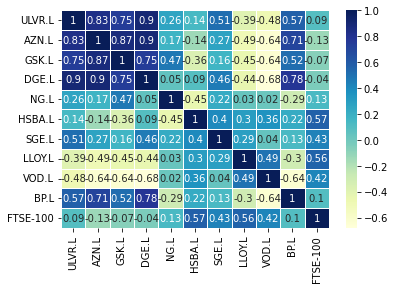

In [365]:
# Plot correlation matrix
fig2 = plt.figure()
sb.heatmap(corr,xticklabels=corr.columns, yticklabels=corr.columns,
cmap='YlGnBu', annot=True, linewidth=0.5)
print('Correlation between stocks in the portfolio')
plt.show(fig2)

In [394]:
# Data of the log-return of the stocks and index
# Import Data
# 10 stocks + risk-free bond from 04/01/17 to 29/11/19 
# data are the log-normal daily returns
stocks_data = pd.read_csv('data1_3.csv', index_col=0)
stocks_data.head()

,ULVR.L,AZN.L,GSK.L,DGE.L,NG.L,HSBA.L,SGE.L,LLOY.L,VOD.L,BP.L,FTSE-100
Date,,,,,,,,,,,
04/01/17,0.003809,0.008412,0.006064,0.011840,-0.008095,0.006438,0.003067,0.002318,0.016173,0.003859,0.001650
05/01/17,0.003492,0.016286,0.007607,0.005166,0.006184,-0.012917,0.000765,-0.001854,0.018066,-0.003859,0.000774
06/01/17,-0.001517,0.000110,0.000000,0.003973,0.003819,0.011274,0.006102,0.019150,0.009031,-0.005428,0.002046
09/01/17,0.015214,0.012448,0.007863,0.012057,0.006649,-0.000150,0.020324,-0.010372,-0.016218,-0.001946,0.003837
10/01/17,-0.002844,0.011330,-0.001254,-0.001845,-0.017080,0.003731,-0.014259,0.020638,0.011000,-0.003511,0.005195


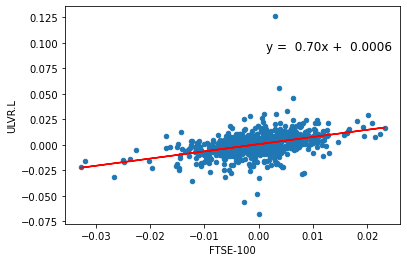

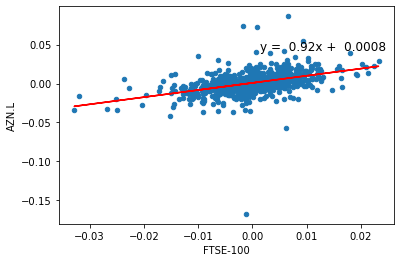

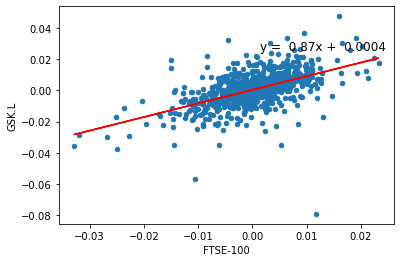

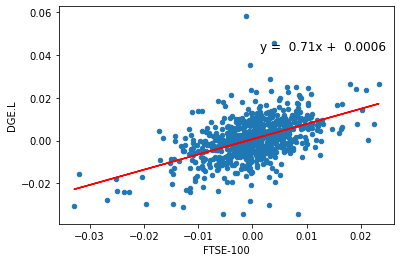

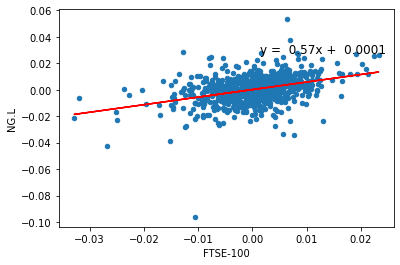

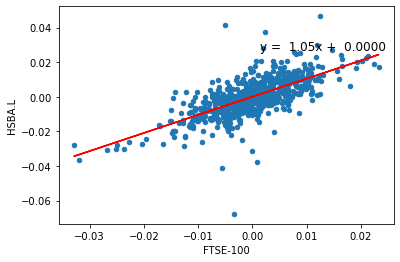

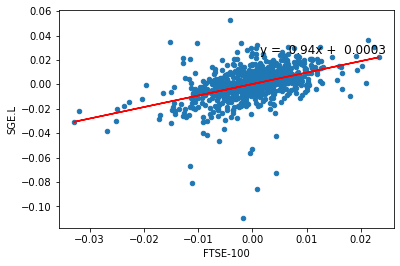

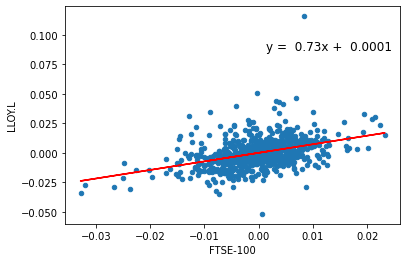

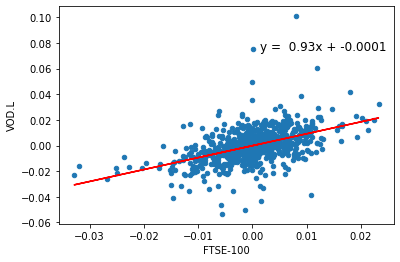

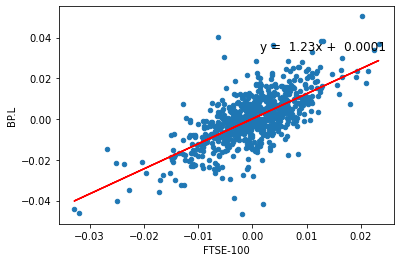

In [391]:
# Calculate Beta for a Portfolio of Stocks
# Beta and Alpha
# Alpha describes the strategy's ability to beat the market (FTSE-100)
# Need the daily log daily return with the FTSE-100
beta = {}
alpha = {}

for i in stocks_data.columns:
    if i != 'Date' and i != 'FTSE-100':
        stocks_data.plot(kind = 'scatter', x = 'FTSE-100', y = i)
        b, a = np.polyfit(stocks_data['FTSE-100'], stocks_data[i], 1)
        plt.plot(stocks_data['FTSE-100'], b * stocks_data['FTSE-100'] + a, '-', color = 'r')
        beta[i] = b
        alpha[i] = a
        equation = f'y = {b: .2f}x + {a: .4f}'
        plt.annotate(equation, (0.6, 0.8), xycoords='axes fraction', fontsize=12)
        plt.show()

In [368]:
# Beta for each stock
beta

{'ULVR.L': 0.7048317393892654,
 'AZN.L': 0.9170104212889696,
 'GSK.L': 0.8741234728168802,
 'DGE.L': 0.7126893611037991,
 'NG.L': 0.5711080170324853,
 'HSBA.L': 1.045859628136267,
 'SGE.L': 0.9415618485846818,
 'LLOY.L': 0.7255469719506449,
 'VOD.L': 0.9300251706063276,
 'BP.L': 1.2280117774598698}

In [369]:
# Alpha of each stock
alpha

{'ULVR.L': 0.0005606666000825683,
 'AZN.L': 0.0008397409798813048,
 'GSK.L': 0.0003941870881325529,
 'DGE.L': 0.0006320430475728703,
 'NG.L': 0.00010099896646099227,
 'HSBA.L': 5.9424702412750945e-06,
 'SGE.L': 0.0002639644446639209,
 'LLOY.L': 7.517378780045427e-05,
 'VOD.L': -0.00013815171161392836,
 'BP.L': 0.00010985267119073283}

In [635]:
# Check performance of the portfolio from 30/11/2017 to 30/12/2022
# Stock prices in the period
period = pd.read_csv('total.csv', index_col=0)
period.head()


,ULVR.L,AZN.L,GSK.L,DGE.L,NG.L,HSBA.L,SGE.L,LLOY.L,VOD.L,BP.L
Date,,,,,,,,,,
30/11/17,3418.677002,4018.912109,916.172913,2237.934570,658.300232,545.147827,668.758423,48.295273,146.774628,353.872864
01/12/17,3378.447754,4010.498047,923.691345,2234.884766,658.300232,542.028442,663.145874,47.380589,146.578339,355.971130
04/12/17,3401.846436,3991.989502,924.049377,2253.617920,658.300232,544.330872,660.987305,47.841595,147.592606,356.694611
05/12/17,3412.929932,3972.639404,915.814941,2271.043945,655.101685,543.365356,660.987305,47.673294,147.396286,355.790192
06/12/17,3430.581299,3973.901367,915.098938,2301.975098,653.018921,538.389282,656.669861,47.424492,147.101807,357.598999


In [636]:
#Labels
labels = ['Unilever', 'AstraZeneca', 'GalaxoSmithKline', 'Diageo', 'National Grid', 'The Sage Group', 'HSBC Holdings',
'Lloyds Banking Group', 'Vodafone Group', 'BP']

In [637]:
# Portfolio 1
weight_p1 = total.iloc[19, 3:]

weightsp1 = weight_p1.values
weightsp1

array([0.16, 0.02, 0.1 , 0.17, 0.12, 0.11, 0.06, 0.16, 0.05, 0.05])

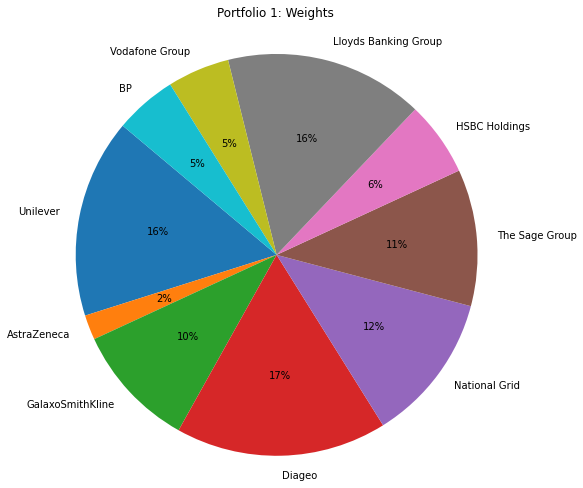

In [638]:
fig, ax = plt.subplots(figsize=(8,8))
fig.patch.set_facecolor('white')
ax.pie(weight_p1.values, labels=labels, autopct='%1.f%%', startangle=140)
ax.axis('equal')

ax.set_title('Portfolio 1: Weights', pad=20)
plt.show()

In [670]:
# Get the daily return of the portfolio
returns = period.pct_change()
portfolio_returnss = (returns * weightsp1).sum(axis=1)

portfolio_returnss

portfolio_performance = pd.DataFrame({'Date': portfolio_returnss.index, 'Portfolio_Return': portfolio_returnss})
portfolio_performance

,Date,Portfolio_Return
Date,,
30/11/17,30/11/17,0.000000
01/12/17,01/12/17,-0.005269
04/12/17,04/12/17,0.004756
05/12/17,05/12/17,-0.000687
06/12/17,06/12/17,0.000610
...,...,...
22/12/22,22/12/22,-0.003981
23/12/22,23/12/22,-0.002496
28/12/22,28/12/22,0.004139


In [671]:
# Download the 'portfolio_returnss' dataframe to a cvs
csv_file_path = 'portfolio_returns.csv'
portfolio_returnss.to_csv(csv_file_path, index=False)
print(f"DataFrame has been saved to '{csv_file_path}' as a CSV file.")

DataFrame has been saved to 'portfolio_returns.csv' as a CSV file.


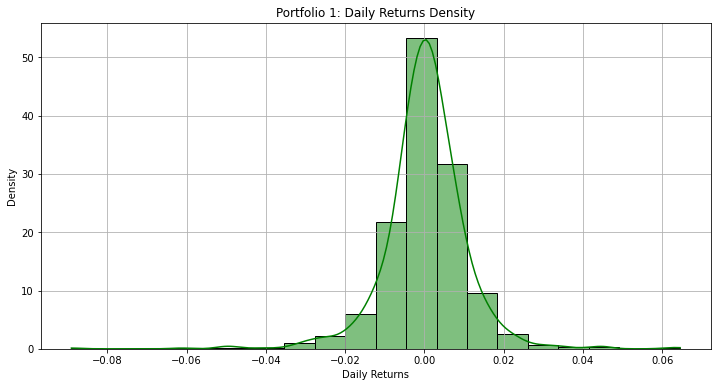

In [672]:
# Plot portfolio returns density with date (showing a subset of dates)
plt.figure(figsize=(12, 6))
sns.histplot(data=portfolio_performance['Portfolio_Return'], bins=20, kde=True, color='green', stat='density')
plt.xlabel('Daily Returns')
plt.ylabel('Density')
plt.title('Portfolio 1: Daily Returns Density')
plt.grid(True)
plt.show()

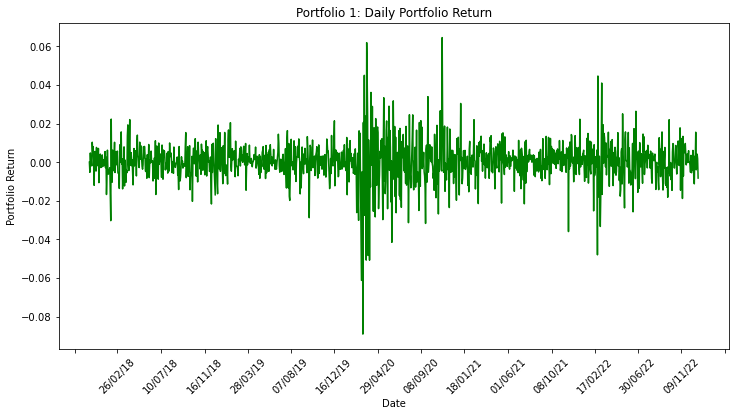

In [673]:
# Plot portfolio returns with date (showing a subset of dates)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(portfolio_performance['Date'], portfolio_performance['Portfolio_Return'], color='green')

# Set the x-axis date format and display every Nth date
N = 3  # Change N to adjust the frequency of displayed dates
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=N))

plt.xlabel('Date')
plt.ylabel('Portfolio Return')
plt.title('Portfolio 1: Daily Portfolio Return')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [674]:
# Average portfolio return
np.average(portfolio_performance['Portfolio_Return'])
average_return = (1+np.average(portfolio_performance['Portfolio_Return']))**252-1
average_return

0.07014706214794098

In [675]:
# Portfolio 2
weight_p2 = total.iloc[23, 3:]

weightsp2 = weight_p2.values
weightsp2

array([0.15, 0.17, 0.06, 0.14, 0.11, 0.04, 0.1 , 0.14, 0.04, 0.05])

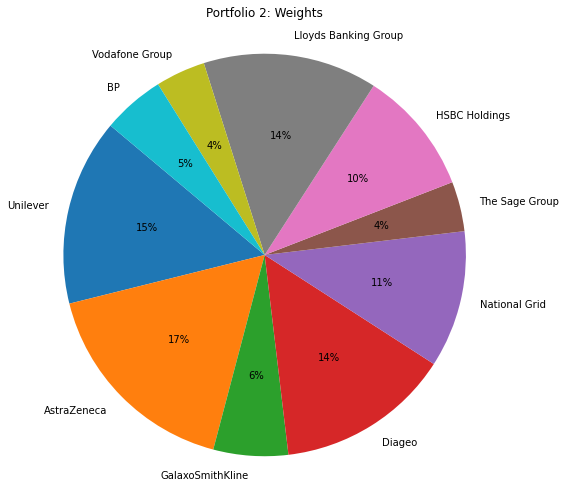

In [676]:
fig, ax = plt.subplots(figsize=(8,8))
fig.patch.set_facecolor('white')
ax.pie(weight_p2.values, labels=labels, autopct='%1.f%%', startangle=140)
ax.axis('equal')

ax.set_title('Portfolio 2: Weights', pad=20)
plt.show()

In [677]:
# Get the daily return of the portfolio
returns = period.pct_change()
portfolio_returnss = (returns * weightsp2).sum(axis=1)

portfolio_returnss

portfolio_performance = pd.DataFrame({'Date': portfolio_returnss.index, 'Portfolio_Return': portfolio_returnss})
portfolio_performance

,Date,Portfolio_Return
Date,,
30/11/17,30/11/17,0.000000
01/12/17,01/12/17,-0.005296
04/12/17,04/12/17,0.003036
05/12/17,05/12/17,-0.001065
06/12/17,06/12/17,0.000764
...,...,...
22/12/22,22/12/22,-0.003584
23/12/22,23/12/22,-0.002941
28/12/22,28/12/22,0.003158


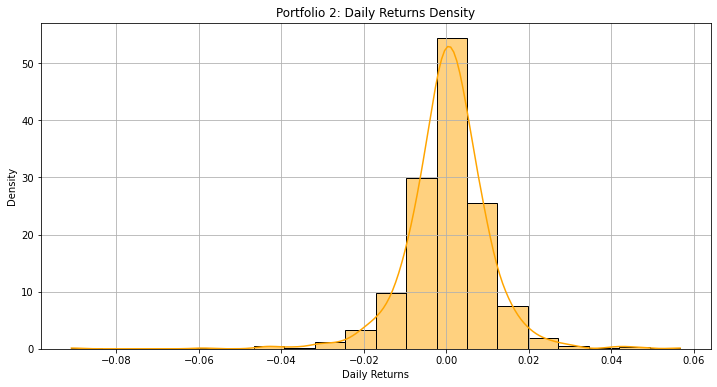

In [678]:
# Plot portfolio returns density with date (showing a subset of dates)
plt.figure(figsize=(12, 6))
sns.histplot(data=portfolio_performance['Portfolio_Return'], bins=20, kde=True, color='orange', stat='density')
plt.xlabel('Daily Returns')
plt.ylabel('Density')
plt.title('Portfolio 2: Daily Returns Density')
plt.grid(True)
plt.show()

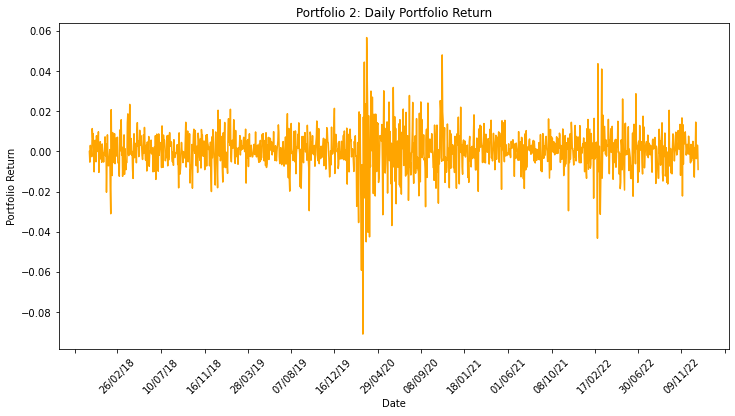

In [679]:
# Plot portfolio returns with date (showing a subset of dates)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(portfolio_performance['Date'], portfolio_performance['Portfolio_Return'], color='orange')

# Set the x-axis date format and display every Nth date
N = 3  # Change N to adjust the frequency of displayed dates
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=N))

plt.xlabel('Date')
plt.ylabel('Portfolio Return')
plt.title('Portfolio 2: Daily Portfolio Return')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [680]:
# Average portfolio return
np.average(portfolio_performance['Portfolio_Return'])
average_return = (1+np.average(portfolio_performance['Portfolio_Return']))**252-1
average_return

0.09846019618009705

In [681]:
# Portfolio 3
weight_p3 = total.iloc[27, 3:]

weightsp3 = weight_p3.values
weightsp3

array([0.26, 0.26, 0.09, 0.05, 0.08, 0.04, 0.05, 0.03, 0.02, 0.12])

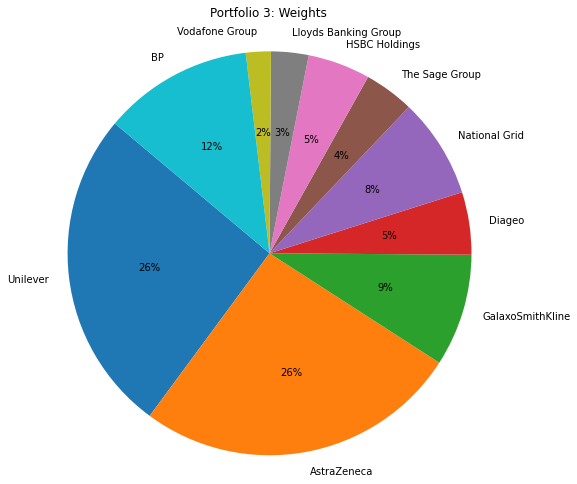

In [682]:
fig, ax = plt.subplots(figsize=(8,8))
fig.patch.set_facecolor('white')
ax.pie(weight_p3.values, labels=labels, autopct='%1.f%%', startangle=140)
ax.axis('equal')

ax.set_title('Portfolio 3: Weights', pad=20)
plt.show()

In [683]:
# Get the daily return of the portfolio
returns = period.pct_change()
portfolio_returnss = (returns * weightsp3).sum(axis=1)

portfolio_returnss

portfolio_performance = pd.DataFrame({'Date': portfolio_returnss.index, 'Portfolio_Return': portfolio_returnss})
portfolio_performance

,Date,Portfolio_Return
Date,,
30/11/17,30/11/17,0.000000
01/12/17,01/12/17,-0.003465
04/12/17,04/12/17,0.001736
05/12/17,05/12/17,-0.001725
06/12/17,06/12/17,0.001504
...,...,...
22/12/22,22/12/22,-0.001448
23/12/22,23/12/22,-0.002496
28/12/22,28/12/22,0.001475


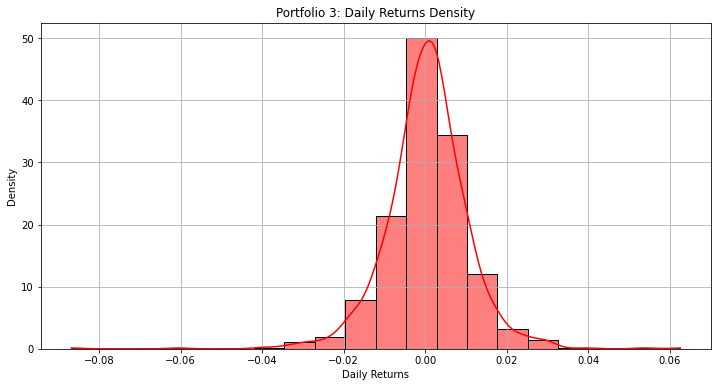

In [684]:
# Plot portfolio returns density with date (showing a subset of dates)
plt.figure(figsize=(12, 6))
sns.histplot(data=portfolio_performance['Portfolio_Return'], bins=20, kde=True, color='red', stat='density')
plt.xlabel('Daily Returns')
plt.ylabel('Density')
plt.title('Portfolio 3: Daily Returns Density')
plt.grid(True)
plt.show()

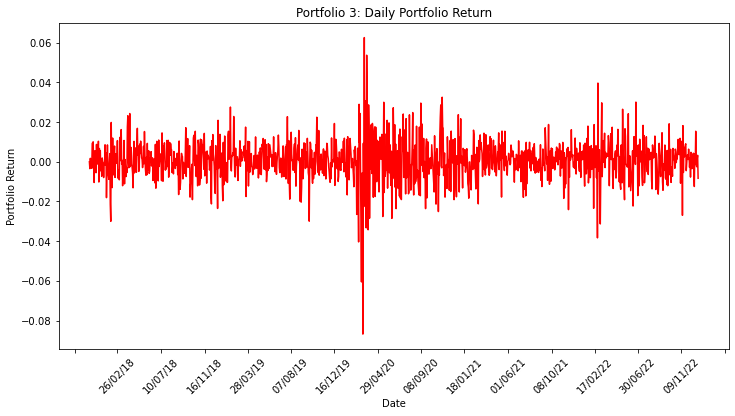

In [685]:
# Plot portfolio returns with date (showing a subset of dates)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(portfolio_performance['Date'], portfolio_performance['Portfolio_Return'], color='red')

# Set the x-axis date format and display every Nth date
N = 3  # Change N to adjust the frequency of displayed dates
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=N))

plt.xlabel('Date')
plt.ylabel('Portfolio Return')
plt.title('Portfolio 3: Daily Portfolio Return')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [686]:
# Average portfolio return
np.average(portfolio_performance['Portfolio_Return'])
average_return = (1+np.average(portfolio_performance['Portfolio_Return']))**252-1
average_return

0.12031359380369766

In [687]:
# PERFORMANCE of the portfolios in the last-year
# 04/01/2022 to 30/08/2023
# Daily stock prices
last_year = pd.read_csv('last_year.csv', index_col=0)
last_year.head()

,ULVR.L,AZN.L,GSK.L,DGE.L,NG.L,HSBA.L,SGE.L,LLOY.L,VOD.L,BP.L
Date,,,,,,,,,,
04/01/22,3747.059326,8107.878418,1486.747192,3926.662598,993.846985,424.402222,802.646545,45.088898,99.971664,324.266510
05/01/22,3712.364746,8095.438477,1493.820679,3887.907715,980.571045,421.521881,802.837402,45.784523,99.087425,327.777161
06/01/22,3673.449707,7995.920410,1478.742798,3807.049316,972.089233,430.478027,786.998230,46.977013,98.810013,328.100464
07/01/22,3689.390625,8037.067383,1487.677979,3707.531250,971.536133,434.123444,786.998230,47.735874,99.347488,334.936829
10/01/22,3719.397217,7974.868652,1499.777344,3682.651611,971.167358,442.854492,770.204895,47.708775,101.826843,335.398773


In [688]:
# Get the daily return of the portfolio
returns = last_year.pct_change()
portfolio_returnss = (returns * weightsp1).sum(axis=1)

portfolio_returnss

portfolio_performance = pd.DataFrame({'Date': portfolio_returnss.index, 'Portfolio_Return': portfolio_returnss})
portfolio_performance

,Date,Portfolio_Return
Date,,
04/01/22,04/01/22,0.000000
05/01/22,05/01/22,-0.002482
06/01/22,06/01/22,-0.002276
07/01/22,07/01/22,0.001719
10/01/22,10/01/22,0.002931
...,...,...
23/08/23,23/08/23,0.007287
24/08/23,24/08/23,0.006339
25/08/23,25/08/23,0.000209


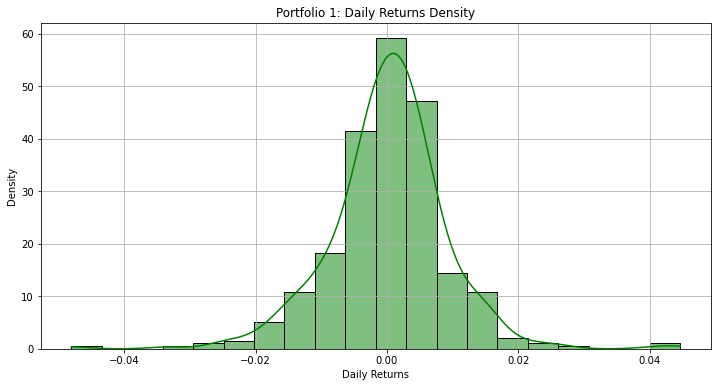

In [689]:
# Plot portfolio returns density with date (showing a subset of dates)
plt.figure(figsize=(12, 6))
sns.histplot(data=portfolio_performance['Portfolio_Return'], bins=20, kde=True, color='green', stat='density')
plt.xlabel('Daily Returns')
plt.ylabel('Density')
plt.title('Portfolio 1: Daily Returns Density')
plt.grid(True)
plt.show()

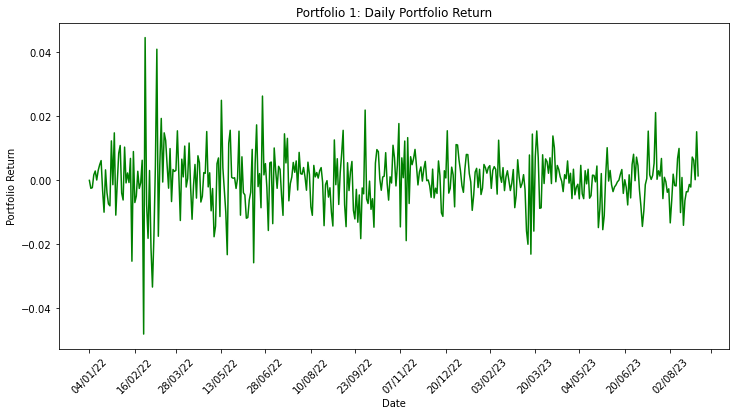

In [690]:
# Plot portfolio returns with date (showing a subset of dates)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(portfolio_performance['Date'], portfolio_performance['Portfolio_Return'], color='green')

# Set the x-axis date format and display every Nth date
N = 1  # Change N to adjust the frequency of displayed dates
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=N))

plt.xlabel('Date')
plt.ylabel('Portfolio Return')
plt.title('Portfolio 1: Daily Portfolio Return')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [691]:
# Average portfolio return
np.average(portfolio_performance['Portfolio_Return'])
average_return = (1+np.average(portfolio_performance['Portfolio_Return']))**252-1
average_return

0.048013051832658915

In [692]:
# Portfolio 2
# Get the daily return of the portfolio
portfolio_returnss = (returns * weightsp2).sum(axis=1)
portfolio_performance = pd.DataFrame({'Date': portfolio_returnss.index, 'Portfolio_Return': portfolio_returnss})
portfolio_performance

,Date,Portfolio_Return
Date,,
04/01/22,04/01/22,0.000000
05/01/22,05/01/22,-0.002116
06/01/22,06/01/22,-0.005670
07/01/22,07/01/22,0.002026
10/01/22,10/01/22,-0.000931
...,...,...
23/08/23,23/08/23,0.007244
24/08/23,24/08/23,0.004452
25/08/23,25/08/23,-0.000836


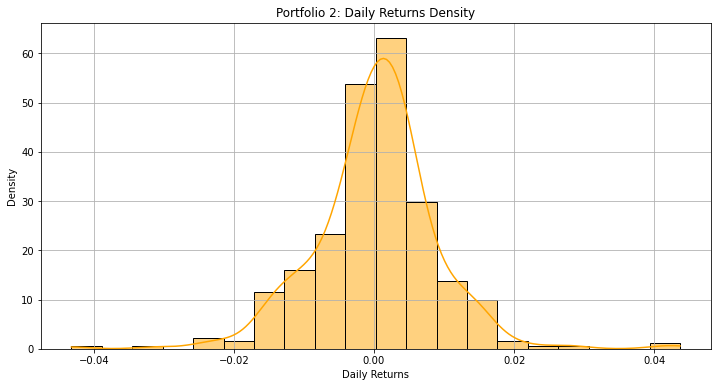

In [693]:
# Plot portfolio returns density with date (showing a subset of dates)
plt.figure(figsize=(12, 6))
sns.histplot(data=portfolio_performance['Portfolio_Return'], bins=20, kde=True, color='orange', stat='density')
plt.xlabel('Daily Returns')
plt.ylabel('Density')
plt.title('Portfolio 2: Daily Returns Density')
plt.grid(True)
plt.show()

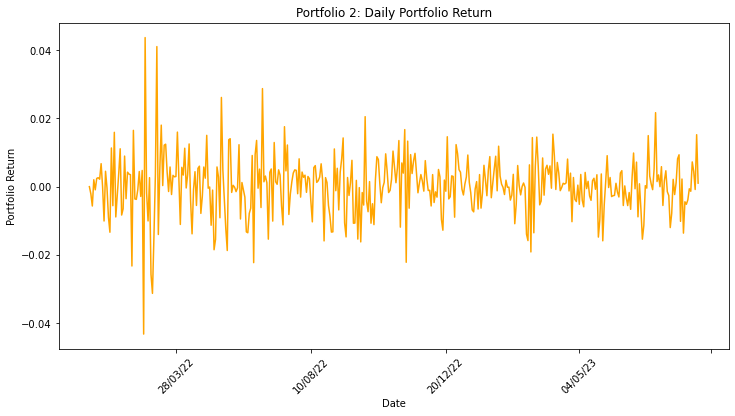

In [694]:
# Plot portfolio returns with date (showing a subset of dates)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(portfolio_performance['Date'], portfolio_performance['Portfolio_Return'], color='orange')

# Set the x-axis date format and display every Nth date
N = 3  # Change N to adjust the frequency of displayed dates
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=N))

plt.xlabel('Date')
plt.ylabel('Portfolio Return')
plt.title('Portfolio 2: Daily Portfolio Return')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [695]:
# Average portfolio return
np.average(portfolio_performance['Portfolio_Return'])
average_return = (1+np.average(portfolio_performance['Portfolio_Return']))**252-1
average_return

0.07158794696245985

In [696]:
# Portfolio 3
# Get the daily return of the portfolio
portfolio_returnss = (returns * weightsp3).sum(axis=1)
portfolio_performance = pd.DataFrame({'Date': portfolio_returnss.index, 'Portfolio_Return': portfolio_returnss})
portfolio_performance

,Date,Portfolio_Return
Date,,
04/01/22,04/01/22,0.000000
05/01/22,05/01/22,-0.002615
06/01/22,06/01/22,-0.007855
07/01/22,07/01/22,0.005090
10/01/22,10/01/22,0.000854
...,...,...
23/08/23,23/08/23,0.005950
24/08/23,24/08/23,0.003509
25/08/23,25/08/23,-0.000130


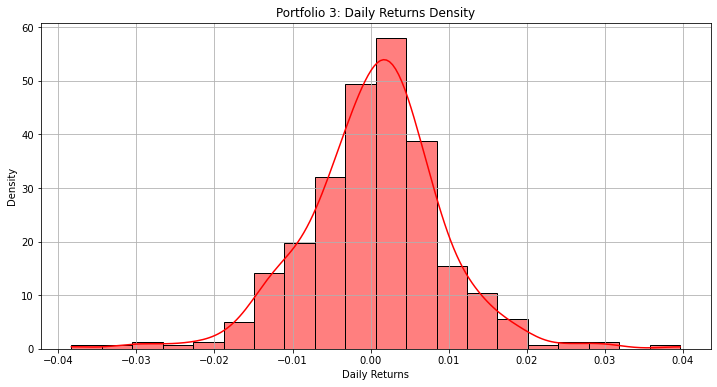

In [697]:
# Plot portfolio returns density with date (showing a subset of dates)
plt.figure(figsize=(12, 6))
sns.histplot(data=portfolio_performance['Portfolio_Return'], bins=20, kde=True, color='red', stat='density')
plt.xlabel('Daily Returns')
plt.ylabel('Density')
plt.title('Portfolio 3: Daily Returns Density')
plt.grid(True)
plt.show()

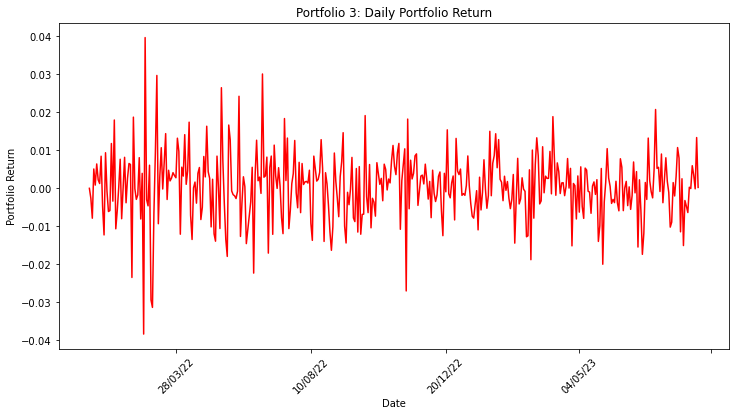

In [698]:
# Plot portfolio returns with date (showing a subset of dates)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(portfolio_performance['Date'], portfolio_performance['Portfolio_Return'], color='red')

# Set the x-axis date format and display every Nth date
N = 3  # Change N to adjust the frequency of displayed dates
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=N))

plt.xlabel('Date')
plt.ylabel('Portfolio Return')
plt.title('Portfolio 3: Daily Portfolio Return')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [699]:
# Average portfolio return
np.average(portfolio_performance['Portfolio_Return'])
average_return = (1+np.average(portfolio_performance['Portfolio_Return']))**252-1
average_return

0.12357787156471578